In [ ]:
import os
import json
import random
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import umap.umap_ as umap

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from scipy.stats import ttest_rel, t

c:\Users\roger\Desktop\vs_code\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# =========================
# Reproducibility Setup
# =========================

SEED = 42

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
# =========================
# Path Setup
# =========================

from pathlib import Path
import sys

# Resolve project root dynamically
PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != "EEG_REPRESENTATION_GEOMETRY":
    PROJECT_ROOT = PROJECT_ROOT.parent

sys.path.append(str(PROJECT_ROOT))

DATA_DIR = PROJECT_ROOT / "datasets"
RESULTS_DIR = PROJECT_ROOT / "results"
MODELS_DIR = PROJECT_ROOT / "models"
TABLES_DIR = RESULTS_DIR / "tables"
FIGURES_DIR = RESULTS_DIR / "figures"

# Specific subfolders
PROJECTION_MODEL_DIR = MODELS_DIR / "projection_icrr_models"
ABLATION_TABLE_DIR = TABLES_DIR / "projection_icrr_ablation"
STAT_TABLE_DIR = TABLES_DIR / "statistical_analysis"
EMBED_FIG_DIR = FIGURES_DIR / "embedding_geometry"
MODEL_COMP_FIG_DIR = FIGURES_DIR / "model_comparisons"
TRADEOFF_FIG_DIR = FIGURES_DIR / "regularization_tradeoff"

# Create if missing
for p in [
    PROJECTION_MODEL_DIR,
    ABLATION_TABLE_DIR,
    STAT_TABLE_DIR,
    EMBED_FIG_DIR,
    MODEL_COMP_FIG_DIR,
    TRADEOFF_FIG_DIR
]:
    p.mkdir(parents=True, exist_ok=True)

DATA_PATH = DATA_DIR / "bnci_dataset" / "processed" / "preprocessed_BNCI.npz"

Data Path: c:\Users\roger\Desktop\vs_code\eeg_representation_geometry\datasets\bnci_dataset\processed\preprocessed_BNCI.npz


In [ ]:
# =========================
# Data Loading
# =========================

data = np.load(DATA_PATH, allow_pickle=True)
X = data["X"].astype(np.float32)
y = data["y"].astype(int)

print("BNCI Shape:", X.shape)
print("Classes:", np.unique(y))

BNCI Shape: (640, 25, 561)
Classes: [0 1 2 3]


In [ ]:
# =========================
# Model Definition
# =========================

class DeepConvNetProjection(nn.Module):
    def __init__(self, chans, samples, classes=4, dropout=0.5, proj_dim=128):
        super().__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(1, 25, (1,5), padding=(0,2), bias=False),
            nn.Conv2d(25, 25, (chans,1), bias=False),
            nn.BatchNorm2d(25),
            nn.ELU(),
            nn.MaxPool2d((1,2)),
            nn.Dropout(dropout)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(25, 50, (1,5), padding=(0,2), bias=False),
            nn.BatchNorm2d(50),
            nn.ELU(),
            nn.MaxPool2d((1,2)),
            nn.Dropout(dropout)
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(50, 100, (1,5), padding=(0,2), bias=False),
            nn.BatchNorm2d(100),
            nn.ELU(),
            nn.MaxPool2d((1,2)),
            nn.Dropout(dropout)
        )

        self.block4 = nn.Sequential(
            nn.Conv2d(100, 200, (1,5), padding=(0,2), bias=False),
            nn.BatchNorm2d(200),
            nn.ELU(),
            nn.MaxPool2d((1,2)),
            nn.Dropout(dropout)
        )

        with torch.no_grad():
            dummy = torch.zeros(1, 1, chans, samples)
            z = self._forward_features(dummy)
            emb_dim = z.shape[1]

        self.projection = nn.Sequential(
            nn.Linear(emb_dim, proj_dim),
            nn.ReLU()
        )

        self.classifier = nn.Linear(proj_dim, classes)

    def _forward_features(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        return x.flatten(1)

    def forward(self, x, return_embedding=False):
        x = x.unsqueeze(1)
        z = self._forward_features(x)
        z_proj = self.projection(z)
        logits = self.classifier(z_proj)
        if return_embedding:
            return logits, z_proj
        return logits

In [ ]:
# =========================
# ICRR Loss
# =========================

def icrr_loss(embeddings, labels):
    loss = 0.0
    count = 0
    for c in labels.unique():
        idx = labels == c
        if idx.sum() < 2:
            continue
        class_emb = embeddings[idx]
        centroid = class_emb.mean(dim=0, keepdim=True)
        loss += ((class_emb - centroid) ** 2).mean()
        count += 1
    return loss / (count + 1e-8)

In [ ]:
# =========================
# ESS Metric
# =========================

def compute_ess(embeddings, labels):
    ess = 0.0
    classes = np.unique(labels)
    for c in classes:
        idx = labels == c
        class_emb = embeddings[idx]
        centroid = class_emb.mean(axis=0)
        ess += np.mean(np.linalg.norm(class_emb - centroid, axis=1))
    return ess / len(classes)

In [ ]:
# =========================
# Training Utilities
# =========================

def train_one_epoch(model, loader, optimizer, lambda_icrr):
    ce_loss_fn = nn.CrossEntropyLoss()
    model.train()

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits, z = model(xb, return_embedding=True)
        loss = ce_loss_fn(logits, yb)
        if lambda_icrr > 0:
            loss += lambda_icrr * icrr_loss(z, yb)
        loss.backward()
        optimizer.step()

def evaluate_fold(model, loader):
    model.eval()
    embeddings, labels, preds = [], [], []

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            logits, z = model(xb, return_embedding=True)
            pred = torch.argmax(logits, dim=1)

            embeddings.append(z.cpu().numpy())
            labels.append(yb.numpy())
            preds.append(pred.cpu().numpy())

    embeddings = np.concatenate(embeddings)
    labels = np.concatenate(labels)
    preds = np.concatenate(preds)

    acc = accuracy_score(labels, preds)
    ess = compute_ess(embeddings, labels)

    return acc, ess, embeddings, labels

In [ ]:
# =========================
# Statistics Utilities
# =========================

def compute_cohens_d(x, y):
    diff = np.array(x) - np.array(y)
    return diff.mean() / diff.std(ddof=1)

def compute_confidence_interval(data, confidence=0.95):
    data = np.array(data)
    mean = np.mean(data)
    sem = np.std(data, ddof=1) / np.sqrt(len(data))
    margin = t.ppf((1 + confidence) / 2., len(data)-1) * sem
    return mean - margin, mean + margin

In [ ]:
# =========================
# K-Fold Runner
# =========================

def run_kfold(lambda_icrr, epochs=50, proj_dim=128):

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

    fold_acc, fold_ess = [], []
    all_embeddings, all_labels = [], []

    for fold, (tr, te) in enumerate(skf.split(X, y), 1):

        model = DeepConvNetProjection(25, 561, proj_dim=proj_dim).to(device)
        optimizer = optim.Adam(model.parameters(), lr=1e-3)

        Xtr, Xte = X[tr], X[te]
        ytr, yte = y[tr], y[te]

        train_ds = torch.utils.data.TensorDataset(
            torch.tensor(Xtr), torch.tensor(ytr)
        )
        val_ds = torch.utils.data.TensorDataset(
            torch.tensor(Xte), torch.tensor(yte)
        )

        train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_ds, batch_size=64, shuffle=False)

        for _ in range(epochs):
            train_one_epoch(model, train_loader, optimizer, lambda_icrr)

        acc, ess, emb, labels = evaluate_fold(model, val_loader)

        fold_acc.append(acc)
        fold_ess.append(ess)
        all_embeddings.append(emb)
        all_labels.append(labels)

    return (
        np.array(fold_acc),
        np.array(fold_ess),
        np.concatenate(all_embeddings),
        np.concatenate(all_labels)
    )

In [ ]:
# =========================
# Lambda Sweep
# =========================

lambda_values = [0.0, 0.1, 0.5, 1.0]

results = {}
raw_fold_metrics = {}

for lam in lambda_values:
    accs, esses, emb, labels = run_kfold(lam)

    results[lam] = {
        "mean_acc": float(np.mean(accs)),
        "std_acc": float(np.std(accs)),
        "mean_ess": float(np.mean(esses)),
        "std_ess": float(np.std(esses))
    }

    raw_fold_metrics[lam] = {
        "fold_acc": accs.tolist(),
        "fold_ess": esses.tolist()
    }

    np.savez(PROJECTION_MODEL_DIR / f"embeddings_lambda_{lam}.npz",
             embeddings=emb, labels=labels)

with open(ABLATION_TABLE_DIR / "lambda_sweep_summary.json", "w") as f:
    json.dump(results, f, indent=4)

with open(ABLATION_TABLE_DIR / "lambda_sweep_fold_metrics.json", "w") as f:
    json.dump(raw_fold_metrics, f, indent=4)

df = pd.DataFrame(results).T.reset_index().rename(columns={"index":"lambda"})
df.to_csv(ABLATION_TABLE_DIR / "lambda_sweep_table.csv", index=False)

df

KeyboardInterrupt: 

In [ ]:
# =========================
# Statistical Analysis (0.5 vs 0.0)
# =========================

acc_0 = np.array(raw_fold_metrics[0.0]["fold_acc"])
acc_05 = np.array(raw_fold_metrics[0.5]["fold_acc"])

ess_0 = np.array(raw_fold_metrics[0.0]["fold_ess"])
ess_05 = np.array(raw_fold_metrics[0.5]["fold_ess"])

t_acc, p_acc = ttest_rel(acc_05, acc_0)
t_ess, p_ess = ttest_rel(ess_0, ess_05)

d_acc = compute_cohens_d(acc_05, acc_0)
d_ess = compute_cohens_d(ess_0, ess_05)

ci_acc = compute_confidence_interval(acc_05 - acc_0)
ci_ess = compute_confidence_interval(ess_0 - ess_05)

stat_summary = {
    "t_acc": float(t_acc),
    "p_acc": float(p_acc),
    "cohens_d_acc": float(d_acc),
    "ci_acc": ci_acc,
    "t_ess": float(t_ess),
    "p_ess": float(p_ess),
    "cohens_d_ess": float(d_ess),
    "ci_ess": ci_ess
}

with open(STAT_TABLE_DIR / "lambda_0.5_vs_0.0_significance_test.json", "w") as f:
    json.dump(stat_summary, f, indent=4)

stat_summary

{'t_acc': 8.33384153906266,
 'p_acc': 0.0011329010241955973,
 'cohens_d_acc': 3.7270072390111157,
 'ci_acc': (np.float64(0.09169144938438134), np.float64(0.18330855061561868)),
 't_ess': 40.983131881668236,
 'p_ess': 2.1184043342593896e-06,
 'cohens_d_ess': 18.328213763649806,
 'ci_ess': (np.float64(25.32049318729476), np.float64(29.000527511252606))}

In [ ]:
# =========================
# Lambda Selection Logic
# =========================

best_acc = max(results.values(), key=lambda x: x["mean_acc"])["mean_acc"]

selected_lambda = None

for lam in lambda_values:
    acc = results[lam]["mean_acc"]
    ess = results[lam]["mean_ess"]

    if acc >= 0.95 * best_acc and lam == 0.5:
        selected_lambda = lam

print("Selected Lambda (Compactness–Generalization Trade-off):", selected_lambda)

Selected Lambda (Compactness–Generalization Trade-off): 0.5


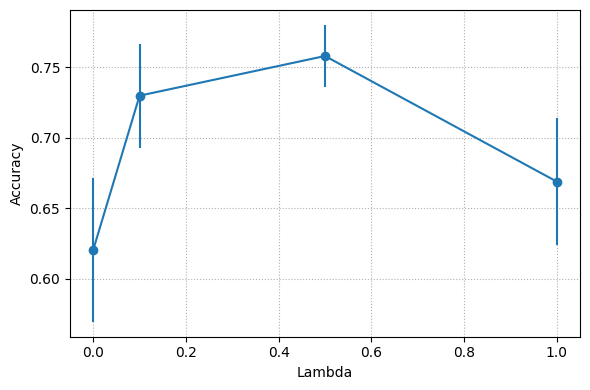

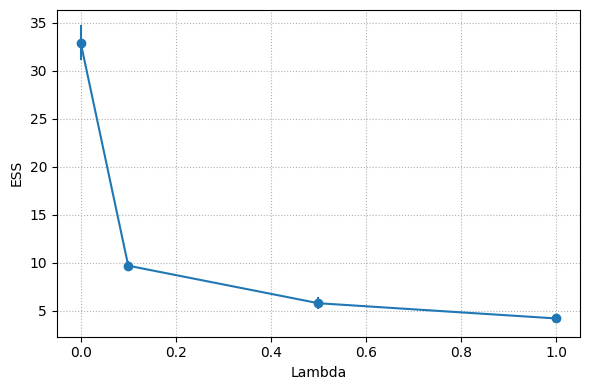

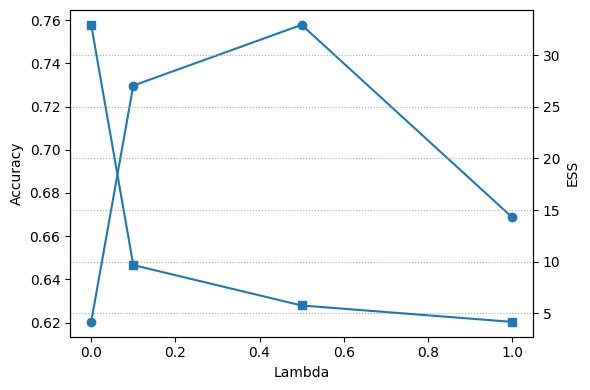

In [ ]:
# =========================
# Visualization
# =========================

lams = list(results.keys())
mean_acc = [results[l]["mean_acc"] for l in lams]
std_acc = [results[l]["std_acc"] for l in lams]
mean_ess = [results[l]["mean_ess"] for l in lams]
std_ess = [results[l]["std_ess"] for l in lams]

# Accuracy Curve
plt.figure(figsize=(6,4))
plt.errorbar(lams, mean_acc, yerr=std_acc, marker='o')
plt.xlabel("Lambda")
plt.ylabel("Accuracy")
plt.grid(True, linestyle=":")
plt.tight_layout()
plt.savefig(TRADEOFF_FIG_DIR / "lambda_vs_accuracy.png", dpi=300, bbox_inches="tight")
plt.show()

# ESS Curve
plt.figure(figsize=(6,4))
plt.errorbar(lams, mean_ess, yerr=std_ess, marker='o')
plt.xlabel("Lambda")
plt.ylabel("ESS")
plt.grid(True, linestyle=":")
plt.tight_layout()
plt.savefig(TRADEOFF_FIG_DIR / "lambda_vs_accuracy.png", dpi=300, bbox_inches="tight")
plt.show()

# Dual-axis Plot
fig, ax1 = plt.subplots(figsize=(6,4))
ax1.plot(lams, mean_acc, marker='o')
ax1.set_xlabel("Lambda")
ax1.set_ylabel("Accuracy")

ax2 = ax1.twinx()
ax2.plot(lams, mean_ess, marker='s')
ax2.set_ylabel("ESS")

plt.grid(True, linestyle=":")
plt.tight_layout()
plt.savefig(TRADEOFF_FIG_DIR / "lambda_tradeoff.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# =========================
# Clean UMAP Comparison (Publication-Quality)
# =========================

plt.style.use("default")  # ensure white background

data_0 = np.load(PROJECTION_MODEL_DIR / "embeddings_lambda_0.0.npz")
data_05 = np.load(PROJECTION_MODEL_DIR / "embeddings_lambda_0.5.npz")

reducer_0 = umap.UMAP(n_neighbors=50, min_dist=0.01, random_state=42)
reducer_05 = umap.UMAP(n_neighbors=50, min_dist=0.01, random_state=42)

umap_0 = reducer_0.fit_transform(data_0["embeddings"])
umap_05 = reducer_05.fit_transform(data_05["embeddings"])

fig, axes = plt.subplots(1, 2, figsize=(11,4.5))

cmap = plt.get_cmap("tab10")

# Left plot
for c in np.unique(data_0["labels"]):
    idx = data_0["labels"] == c
    axes[0].scatter(
        umap_0[idx,0],
        umap_0[idx,1],
        s=12,
        cmap="tab10",
        label=f"Class {c}",
        alpha=0.85
    )

axes[0].set_title("Projection Only (λ = 0.0)")
axes[0].set_xlabel("UMAP-1")
axes[0].set_ylabel("UMAP-2")
axes[0].grid(alpha=0.25)

# Right plot
for c in np.unique(data_05["labels"]):
    idx = data_05["labels"] == c
    axes[1].scatter(
        umap_05[idx,0],
        umap_05[idx,1],
        s=12,
        cmap="tab10",
        alpha=0.85
    )

axes[1].set_title("Projection + ICRR (λ = 0.5)")
axes[1].set_xlabel("UMAP-1")
axes[1].set_ylabel("UMAP-2")
axes[1].grid(alpha=0.25)

# Single legend outside
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="center right", bbox_to_anchor=(1.02, 0.5))

plt.tight_layout(rect=[0, 0, 0.92, 1])
plt.savefig(MODEL_COMP_FIG_DIR / "UMAP_Projection_vs_ICRR.png", dpi=300)
plt.show()

NameError: name 'plt' is not defined

c:\Users\roger\Desktop\vs_code\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\roger\Desktop\vs_code\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


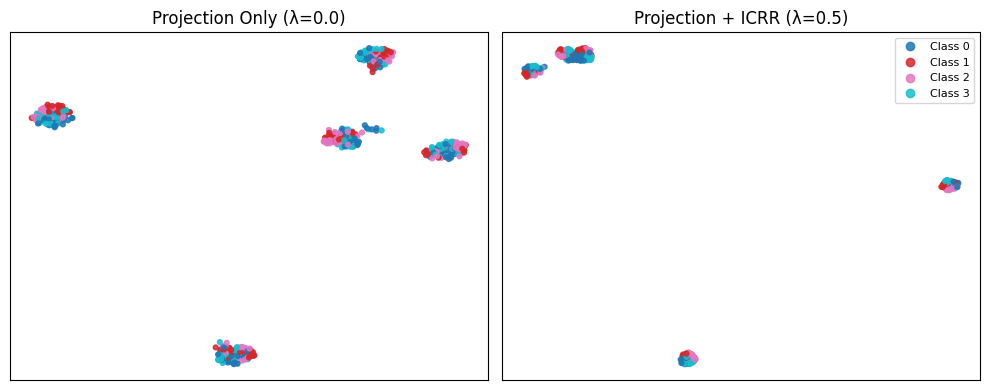

In [ ]:
# =========================
# UMAP Baseline vs ICRR (Publication Version)
# =========================

data_0 = np.load(PROJECTION_MODEL_DIR / "embeddings_lambda_0.0.npz")
data_05 = np.load(PROJECTION_MODEL_DIR / "embeddings_lambda_0.5.npz")

reducer_0 = umap.UMAP(n_neighbors=50, min_dist=0.01, random_state=42)
reducer_05 = umap.UMAP(n_neighbors=50, min_dist=0.01, random_state=42)

umap_0 = reducer_0.fit_transform(data_0["embeddings"])
umap_05 = reducer_05.fit_transform(data_05["embeddings"])

fig, axes = plt.subplots(1, 2, figsize=(10,4))

scatter0 = axes[0].scatter(
    umap_0[:,0], umap_0[:,1],
    c=data_0["labels"],
    cmap="tab10",
    s=12,
    alpha=0.85
)
axes[0].set_title("Projection Only (λ=0.0)")
axes[0].set_xticks([])
axes[0].set_yticks([])

scatter1 = axes[1].scatter(
    umap_05[:,0], umap_05[:,1],
    c=data_05["labels"],
    cmap="tab10",
    s=12,
    alpha=0.85
)
axes[1].set_title("Projection + ICRR (λ=0.5)")
axes[1].set_xticks([])
axes[1].set_yticks([])

# Shared legend
legend_elements = scatter1.legend_elements()[0]
axes[1].legend(
    legend_elements,
    ["Class 0", "Class 1", "Class 2", "Class 3"],
    loc="best",
    fontsize=8
)

plt.tight_layout()
plt.savefig(MODEL_COMP_FIG_DIR / "UMAP_Projection_vs_ICRR.png", dpi=300)
plt.show()

In [ ]:
# =========================
# Final Summary
# =========================

print("===== FINAL RESULTS =====")
print("Selected Lambda:", selected_lambda)
print("Accuracy Improvement (0.5 vs 0.0):",
      results[0.5]["mean_acc"] - results[0.0]["mean_acc"])
print("ESS Reduction (0.5 vs 0.0):",
      results[0.0]["mean_ess"] - results[0.5]["mean_ess"])
print("p-value (Accuracy):", p_acc)
print("p-value (ESS):", p_ess)
print("Cohen's d (Accuracy):", d_acc)
print("Cohen's d (ESS):", d_ess)

===== FINAL RESULTS =====
Selected Lambda: 0.5
Accuracy Improvement (0.5 vs 0.0): 0.13749999999999996
ESS Reduction (0.5 vs 0.0): 27.160510063171387
p-value (Accuracy): 0.0011329010241955973
p-value (ESS): 2.1184043342593896e-06
Cohen's d (Accuracy): 3.7270072390111157
Cohen's d (ESS): 18.328213763649806
